In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, balanced_accuracy_score
import numpy as np
import pickle
from sklearn.impute import KNNImputer
import imblearn
from sklearn import metrics

from sklearn.ensemble import RandomForestRegressor
from utils.general_utils import save_model
from sklearn.model_selection import train_test_split, GridSearchCV,cross_val_score, RepeatedStratifiedKFold
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, balanced_accuracy_score
import imblearn
from imblearn.pipeline import Pipeline

from sklearn.manifold import TSNE # TSNE module
from sklearn.decomposition import PCA



from utils.general_utils import get_outlier_info, get_outlier_val_counts
from utils.saver_utils import save_normalizer, load_normalizer
from utils.saver_utils import save_dataset, load_dataset 

In [21]:
from scipy import stats

In [2]:
datasetv2_save_path = "dataset/dataset_v2"
imputed_df = pd.read_csv(f'{datasetv2_save_path}/imputed_df.csv', index_col=0)
imputed_df.head()

,pcr,rfs,Age,ER,PgR,LNStatus,original_shape_Elongation,original_shape_Flatness,original_shape_LeastAxisLength,original_shape_MajorAxisLength,...,ChemoGrade_1.0,ChemoGrade_2.0,ChemoGrade_3.0,Proliferation_1.0,Proliferation_2.0,Proliferation_3.0,TumourStage_1.0,TumourStage_2.0,TumourStage_3.0,TumourStage_4.0
0,1.0,144.0,41.0,0.0,0.0,1.0,0.813912,0.724080,23.781937,32.844370,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
1,0.0,142.0,39.0,1.0,1.0,1.0,0.666118,0.476173,20.715461,43.504095,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
2,1.0,135.0,31.0,0.0,0.0,0.0,0.645083,0.594470,21.659822,36.435505,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
3,0.0,12.0,35.0,0.0,0.0,1.0,0.770842,0.501228,26.590504,53.050724,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
4,0.0,109.0,61.0,1.0,0.0,0.0,0.861035,0.750267,20.456571,27.265716,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0


In [32]:
train, test = train_test_split(imputed_df, test_size=0.20)

In [35]:
multi_category_variables = ['ChemoGrade_1.0', 'ChemoGrade_2.0', 'ChemoGrade_3.0', 'Proliferation_1.0', 'Proliferation_2.0',
       'Proliferation_3.0', 'TumourStage_1.0', 'TumourStage_2.0', 'TumourStage_3.0', 'TumourStage_4.0']

categorical_features_labels = ['ER', 'PgR', 'LNStatus'] + multi_category_variables

continous_features_labels = imputed_df.drop(columns=categorical_features_labels+['pcr', 'rfs']).columns

In [36]:
train_continous_feature_array = train[continous_features_labels].to_numpy()

test_continous_feature_array = test[continous_features_labels].to_numpy()

In [37]:
scalerTrainX = StandardScaler()
scalerTrainY = StandardScaler()


train_cont_X = scalerTrainX.fit_transform(train_continous_feature_array)
train_cat_X = train[categorical_features_labels].to_numpy()
trainX = np.hstack((train_cat_X, train_cont_X))
                   
trainY = scalerTrainY.fit_transform(train['rfs'].to_numpy().reshape(-1, 1))

                   
test_cont_X = scalerTrainX.transform(test_continous_feature_array)
test_cat_X = test[categorical_features_labels].to_numpy()
testX = np.hstack((test_cat_X, test_cont_X))
                   
testY = scalerTrainY.transform(test['rfs'].to_numpy().reshape(-1, 1))


In [38]:
trainX.shape, trainY.shape, testX.shape, testY.shape

((320, 60), (320, 1), (80, 60), (80, 1))

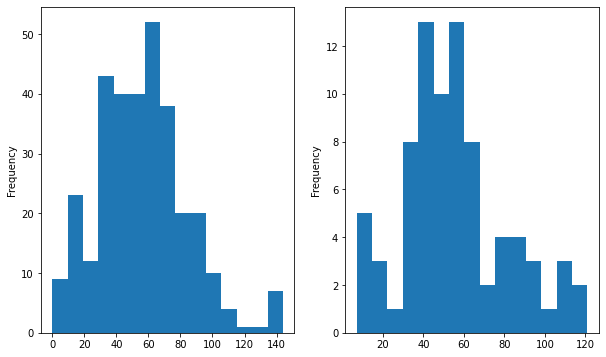

In [34]:
fig, axes = plt.subplots(1,2, figsize=(10, 6))

train['rfs'].plot(kind='hist', bins=15, ax=axes[0])
test['rfs'].plot(kind='hist', bins=15, ax=axes[1])

plt.show()

In [33]:
stats.ttest_ind(train['rfs'], test['rfs'], alternative='two-sided')

TtestResult(statistic=0.46292303297726867, pvalue=0.6436725443819507, df=398.0)

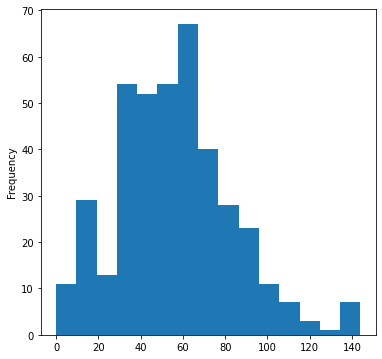

In [8]:
plt.figure(figsize=(6, 6))
imputed_df['rfs'].plot(kind='hist', bins=15)
plt.hist()
plt.show()

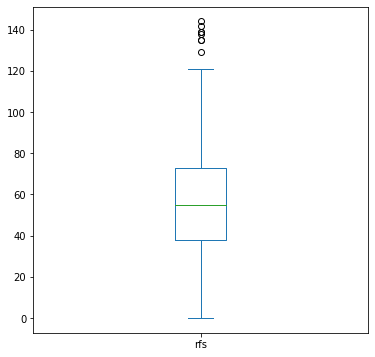

In [9]:
plt.figure(figsize=(6, 6))
imputed_df['rfs'].plot(kind='box')
plt.show()

In [10]:
lower_outlier_gate, upper_outlier_gate = get_outlier_info(imputed_df['rfs'])
get_outlier_val_counts(imputed_df['rfs'], lower_outlier_gate, upper_outlier_gate)

{-14.5: [0, Series([], Name: rfs, dtype: float64)],
 125.5: [8, 0     144.0
  1     142.0
  2     135.0
  5     135.0
  6     139.0
  8     139.0
  9     138.0
  10    129.0
  Name: rfs, dtype: float64]}

In [39]:
regressor = RandomForestRegressor(random_state=0, verbose=1)
regressor.fit(trainX, trainY.ravel())

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.5s


RandomForestRegressor(random_state=0, verbose=1)

In [40]:
predicted = regressor.predict(testX)
test_mse_error = mean_squared_error(predicted, testY)
test_mae_error = mean_absolute_error(predicted, testY)
test_r2_error = r2_score(predicted, testY)

print(f'MSE error: {test_mse_error}')
print(f'MAE error: {test_mae_error}')
print(f'R2 error: {test_r2_error}')

MSE error: 0.8381184192449063
MAE error: 0.7300703325159568
R2 error: -4.764195755189404


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s


In [41]:
pca = PCA(n_components=6)
pca_6d = pca.fit_transform(trainX)

In [42]:
regressor = RandomForestRegressor(random_state=0, verbose=1)
regressor.fit(pca_6d, trainY.ravel())

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s


RandomForestRegressor(random_state=0, verbose=1)

In [43]:
predicted = regressor.predict(pca.transform(testX))
test_mse_error = mean_squared_error(predicted, testY)
test_mae_error = mean_absolute_error(predicted, testY)
test_r2_error = r2_score(predicted, testY)

print(f'MSE error: {test_mse_error}')
print(f'MAE error: {test_mae_error}')
print(f'R2 error: {test_r2_error}')

MSE error: 0.8434375879196239
MAE error: 0.7172646297280019
R2 error: -6.169478558997657


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s


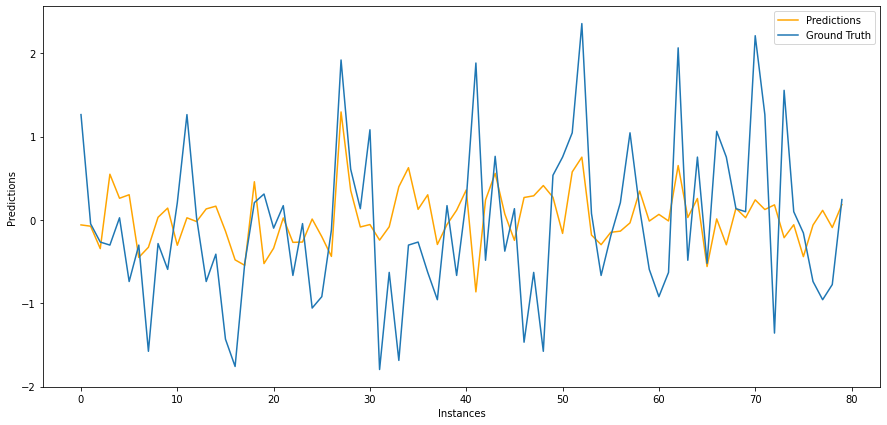

In [44]:
plt.figure(figsize=(15,7))
plt.plot(list(range(len(predicted))), predicted, color='orange', label='Predictions')
plt.plot(list(range(len(predicted))), testY.flatten(), label='Ground Truth')
plt.xlabel("Instances")
plt.ylabel("Predictions")
plt.legend()
plt.show()